# Gillespie Algorithm for a SIR Model with Wise and Risky Indiviuals
### by Luca Sbano (Theory & Implementation) and Steffen Bauer (Implementation & Jupyter)
***

__Definitions:__
<br>

|Variable | Meaning                                             |
|---------|-----------------------------------------------------|
|$W$:     | susceptible and wise                                |
|$R$:     | susceptible and risky                               |
|$I$:     | infectious                                          |
|$D$:     | dead                                                |
|$S$:     | individuals cured and who can no longer be infected |

__Reactions:__
<br>
$$
\begin{align}
    W &\rightarrow^a R\\
    R &\rightarrow^{\alpha} W\\
    R + I &\rightarrow^c 2I\\
    W + I &\rightarrow^b 2I\\
    I &\rightarrow^{\beta} W\\
    I &\rightarrow^d D\\
    I &\rightarrow^{\rho} S
\end{align}
$$

## Algorithm


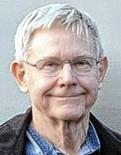

>1. Generate two random numbers $r_1$, $r_2$ uniformly distributed in
$[0, 1]$.
2. Compute $\mathcal{R}_0 := \sum_{j=1}^r \mathcal{R}_j$.
3. Compute $\tau := \frac{1}{\mathcal{R}_0} \ln[\frac{1}{r_1}]$.
4. Set time of next rule execution to $t + \tau$.
5. Compute wich rule is executed at time $t + \tau$. Find $j$ such that
$$
\frac{1}{\mathcal{R}_0} \sum_{i=1}^{j-1} \mathcal{R}_i < r_2 \leq  \frac{1}{\mathcal{R}_0} \sum_{i=1}^{j} \mathcal{R}_i
$$
6. Execute rule $R_j$ and update to new system configuration.
7. Go to step 1 with updated time $t::= t + \tau$ (where $::=$ means replacement) if $t < T$, otherwise stop.

(If you want to see Daniel Gillespie presenting his algorithm in 2017, go to [youtube](https://youtu.be/atOc2v8Wtcw).)

## Implementation

First load some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
from IPython.display import display

Define the algorithm [above](#Algorithm) as a function (later used for interactivity):

In [2]:
def gillespie(rWiseToRisky     = 0.1, 
              rRiskyToWise     = 0.03, 
              rWiseToInfected  = 0.001, 
              rRiskyToInfected = 0.01,
              rCure            = 0.2,
              rFatalities      = 0.08,
              rRecover         = 0.1,
              n                = 800
             ):
    '''
    Gillespie algorithm to solve SIR model for wise and risky people
    Implementation of Gillespie algorithm and SIR model: Luca Sbano
    Slight modifications for interactivity with slider : Steffen Bauer
    Extension : Giovanni Luis Crocioni
    '''
    
    # Input parameters 
    N     = n              #        int;   total population  
    T     = 100.0            #        float; maximum elapsed time 
    t     = 0.0              #        float; start time
    a     = rWiseToRisky     # (0.1)  float; rate of wise to risky
    alpha = rRiskyToWise     # (0.03) float; rate of risky to wise
    b     = rWiseToInfected  # (0.001)float; rate of wise to infected
    c     = rRiskyToInfected # (0.01) float; rate of risky to infected
    beta  = rCure            # (0.2)  float; rate of cure
    d     = rFatalities      # (0.08) float; rate of fatalities
    rho   = rRecover         # (0.1)  float; rate of recovering and getting immunity
    
    n_I   = 1                #        int;   initial Infected population
    n_D   = 0                #        int;   initial conditions on Dead people 
    n_S   = 0                #        int;   initial conditions on Saved people 
    n_R   = 50               #        int;   initial conditions on Risky people
    n_W   = N - n_I - n_R    #        int;   initial conditions on Wise people

    # Initialize results list
    MAXITER       = 10000
    SIR_data      = np.zeros((MAXITER  + 1, 6))
    SIR_data[0,:] = [t, n_W, n_I, n_R, n_S, n_D]

    it = 0
    
    #To measure the values of the data points
    data_points = {'nW': [], 'nI': [], 'nR': [], 'nS': [], 'nD': []}
    point_counter = 0
    
    # Main loop
    while t < T and it < MAXITER:
        if n_I == 0:
            break
        it += 1

        # Rates/Weights calculation
        w1 = a * n_W
        w2 = alpha * n_R
        w3 = c * n_I * n_R
        w4 = b * n_I * n_W
        w5 = beta * n_I
        w6 = d * n_I
        w7 = rho * n_I
        W  = w1 + w2 + w3 + w4 + w5 + w6 + w7
        
        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / W
        t   = t + dt
        
        #Store the value of data points
        if t >= 10 and point_counter < 1:
            data_points['nW'].append(n_W)
            data_points['nI'].append(n_I)
            data_points['nR'].append(n_R)
            data_points['nS'].append(n_S)
            data_points['nD'].append(n_D)
            point_counter += 1

        #Second uniformily distributed ranmdom number
        r_2 = np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < w1 / W:
            n_W = n_W - 1
            n_R = n_R + 1
        if r_2>=w1/W and r_2 < (w1+w2) / W:
            n_R = n_R - 1
            n_W = n_W + 1
        if r_2>=(w1+w2)/W and r_2 < (w1+w2+w3)/W:
            n_R = n_R - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3)/W and r_2 < (w1+w2+w3+w4)/W:
            n_W = n_W - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3+w4)/W and r_2 < (w1+w2+w3+w4+w5)/W:
            n_I = n_I - 1
            n_W = n_W + 1
        if r_2>=(w1+w2+w3+w4+w5)/W and r_2< (w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_D = n_D + 1
        if r_2 >(w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_S = n_S + 1
        
        #print("{:f} \t {:d} \t {:d} \t {:d} \t {:d} \t {:d}".format(t, n_W, n_I, n_R, n_S, n_D))
        SIR_data[it, :] = [t, n_W, n_I, n_R, n_S, n_D]
    
    #Plotting
    SIR  = SIR_data[:it,:]
    time = SIR[:,0]
    nW   = SIR[:,1]
    nI   = SIR[:,2]
    nR   = SIR[:,3]
    nS   = SIR[:,4]
    nD   = SIR[:,5]

    fig, ax = plt.subplots(figsize=(15,5))
    line1,=ax.plot(time,nW, label='$n_W$')
    line2,=ax.plot(time,nI, label='$n_I$')
    line3,=ax.plot(time,nR, label='$n_R$')
    line4,=ax.plot(time,nS, label='$n_S$')
    line5,=ax.plot(time,nD, label='$n_D$')
    
    legend = ax.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax.set_xlim(0., T)
    ax.set_ylim(0., N)
    
    plt.title('Simulation of a SIR model')
    plt.xlabel('time')
    plt.ylabel('Individuals')

    plt.show()
    #return data_points

You could call the function simply by 
`gillespie()` or `gillespie(rWiseToRisky = 0.8)` if you want to chance the parameters / reaction rates.

But we can add interactivity by simply using `interact(function, paramters = (min, max, stepsize))`. And we get some lovely sliders.

_(Please, be patient and wait for updating of the graph.)_

In [3]:
interact(gillespie, rWiseToRisky     = (0.,1.,0.01), 
                    rRiskyToWise     = (0.,1.,0.01), 
                    rWiseToInfected  = (0.,1.,0.001),
                    rRiskyToInfected = (0.,1.,0.01),
                    rCure            = (0.,1.,0.01),
                    rFatalities      = (0.,1.,0.01),
                    rRecover         = (0.,1.,0.01),
                    n                = (200,800,1));

interactive(children=(FloatSlider(value=0.1, description='rWiseToRisky', max=1.0, step=0.01), FloatSlider(valu…

Now it's time to play with all these parameters. Choose them wisely!;-P 

From here on, the code is Giovanni Luis Crocioni's.

I chose the following parameters for the model, having tested a few different combinations. Below is a realisation of it.

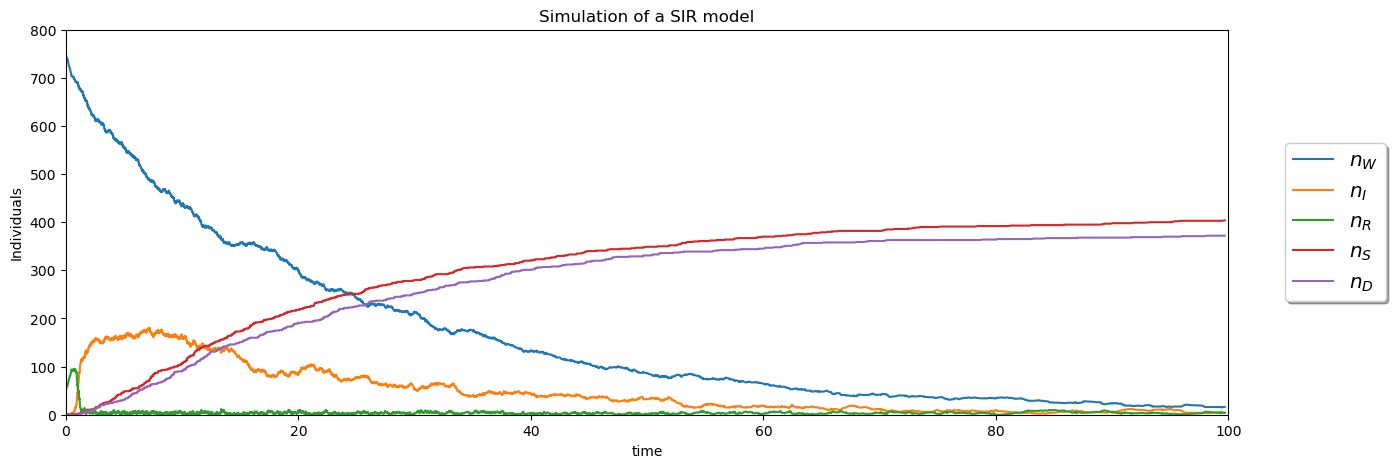

In [4]:
gillespie(rWiseToRisky     = 0.10, 
          rRiskyToWise     = 0.03, 
          rWiseToInfected  = 0.00, 
          rRiskyToInfected = 0.10,
          rCure            = 0.20,
          rFatalities      = 0.08,
          rRecover         = 0.08,
          n                = 800)

I will use the test to check that the algorithmn runs to beyond 50 time steps with high probabibility. I also check that i exceeds the vlaue of 1, because sometimes the one infected person either dies or is saved, so the parameters chosen need to minimise this risk while also maximising the chance of exceeding 50. Averaging over many iterations, 95% of the time we get a desired result.

In [5]:
#Same as the original gillespie algorithm, however doesn't return a plot but allows us to check it runs past 50 
#and past 1 often
def gillespie_test(rWiseToRisky     = 0.10, 
                   rRiskyToWise     = 0.03, 
                   rWiseToInfected  = 0.00, 
                   rRiskyToInfected = 0.10,
                   rCure            = 0.20,
                   rFatalities      = 0.08,
                   rRecover         = 0.08,
                   n                = 800):

    # Input parameters 
    N     = n              #        int;   total population  
    T     = 100.0            #        float; maximum elapsed time 
    t     = 0.0              #        float; start time
    a     = rWiseToRisky     # (0.1)  float; rate of wise to risky
    alpha = rRiskyToWise     # (0.03) float; rate of risky to wise
    b     = rWiseToInfected  # (0.001)float; rate of wise to infected
    c     = rRiskyToInfected # (0.01) float; rate of risky to infected
    beta  = rCure            # (0.2)  float; rate of cure
    d     = rFatalities      # (0.08) float; rate of fatalities
    rho   = rRecover         # (0.1)  float; rate of recovering and getting immunity
    
    n_I   = 1                #        int;   initial Infected population
    n_D   = 0                #        int;   initial conditions on Dead people 
    n_S   = 0                #        int;   initial conditions on Saved people 
    n_R   = 50               #        int;   initial conditions on Risky people
    n_W   = N - n_I - n_R    #        int;   initial conditions on Wise people

    # Initialize results list
    MAXITER       = 10000
    it = 0
    check50 = 0
    check1 = 0
    
    # Main loop
    while t < T and it < MAXITER:
        if n_I == 0:
            break
        it += 1

        # Rates/Weights calculation
        w1 = a * n_W
        w2 = alpha * n_R
        w3 = c * n_I * n_R
        w4 = b * n_I * n_W
        w5 = beta * n_I
        w6 = d * n_I
        w7 = rho * n_I
        W  = w1 + w2 + w3 + w4 + w5 + w6 + w7
        
        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / W
        t   = t + dt
        

        #Second uniformily distributed ranmdom number
        r_2 = np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < w1 / W:
            n_W = n_W - 1
            n_R = n_R + 1
        if r_2>=w1/W and r_2 < (w1+w2) / W:
            n_R = n_R - 1
            n_W = n_W + 1
        if r_2>=(w1+w2)/W and r_2 < (w1+w2+w3)/W:
            n_R = n_R - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3)/W and r_2 < (w1+w2+w3+w4)/W:
            n_W = n_W - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3+w4)/W and r_2 < (w1+w2+w3+w4+w5)/W:
            n_I = n_I - 1
            n_W = n_W + 1
        if r_2>=(w1+w2+w3+w4+w5)/W and r_2< (w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_D = n_D + 1
        if r_2 >(w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_S = n_S + 1
        
    
    if t > 50:
        check50 += 1
    else:
        pass
    
    if t < 1:
        check1 += 1
    else:
        pass
    
    return check50, check1

In [6]:
#Initialise certain values
iterations = 100
count50 = 0
count1 = 0
count = 0

#Looping over many realisations of the algorithm
for _ in range(iterations):
    check50, check1 = gillespie_test()  # Call gillespie_test() once to get both values
    count50 += check50                  # If it runs past time t=50
    count1  += check1                   # If it doesn't run past t=1
    count   += 1

#Calculating the probabilities of both events
prob_pass_50 = count50 / count if count != 0 else 0
prob_not_pass_1 = count1 / count if count != 0 else 0

print(f'The probability of the algorithm exceeding t = 50 is: {prob_pass_50 * 100:.2f}%')
print(f'The probability of the algorithm not exceeding t = 1 is: {prob_not_pass_1 * 100:.2f}%')

The probability of the algorithm exceeding t = 50 is: 91.00%
The probability of the algorithm not exceeding t = 1 is: 9.00%


In [15]:
#Gillespie algorithm function that gives us the values of each category at a given time
def gillespie1(rWiseToRisky     = 0.10,
               rRiskyToWise     = 0.03, 
               rWiseToInfected  = 0.00, 
               rRiskyToInfected = 0.10,
               rCure            = 0.20,
               rFatalities      = 0.08,
               rRecover         = 0.08,
               Time             = 10,
               n                = 800):
               
    '''
    Gillespie algorithm to solve SIR model for wise and risky people
    Implementation of Gillespie algorithm and SIR model: Luca Sbano
    Slight modifications for interactivity with slider : Steffen Bauer
    Extension : Giovanni Luis Crocioni
    '''
    
    # Input parameters 
    N     = n              #        int;   total population  
    T     = 100.0            #        float; maximum elapsed time 
    t     = 0.0              #        float; start time
    a     = rWiseToRisky     # (0.1)  float; rate of wise to risky
    alpha = rRiskyToWise     # (0.03) float; rate of risky to wise
    b     = rWiseToInfected  # (0.001)float; rate of wise to infected
    c     = rRiskyToInfected # (0.01) float; rate of risky to infected
    beta  = rCure            # (0.2)  float; rate of cure
    d     = rFatalities      # (0.08) float; rate of fatalities
    rho   = rRecover         # (0.1)  float; rate of recovering and getting immunity
    
    n_I   = 1                #        int;   initial Infected population
    n_D   = 0                #        int;   initial conditions on Dead people 
    n_S   = 0                #        int;   initial conditions on Saved people 
    n_R   = 50               #        int;   initial conditions on Risky people
    n_W   = N - n_I - n_R    #        int;   initial conditions on Wise people

    # Initialize results list
    MAXITER       = 10000
    it = 0
    z = 0
    
    #To measure the values of the data points
    data_nW = 0
    data_nI = 0
    data_nR = 0
    data_nS = 0
    data_nD = 0
    
    # Main loop
    while t < T and it < MAXITER:
        if n_I == 0:
            break
        it += 1

        # Rates/Weights calculation
        w1 = a * n_W
        w2 = alpha * n_R
        w3 = c * n_I * n_R
        w4 = b * n_I * n_W
        w5 = beta * n_I
        w6 = d * n_I
        w7 = rho * n_I
        W  = w1 + w2 + w3 + w4 + w5 + w6 + w7
        
        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / W
        t   = t + dt
        
        #Store the value of data points
        if t >= Time and z < 1:
            data_nW = n_W
            data_nI = n_I
            data_nR = n_R
            data_nS = n_S
            data_nD = n_D
            z += 1

        #Second uniformily distributed ranmdom number
        r_2 = np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < w1 / W:
            n_W = n_W - 1
            n_R = n_R + 1
        if r_2>=w1/W and r_2 < (w1+w2) / W:
            n_R = n_R - 1
            n_W = n_W + 1
        if r_2>=(w1+w2)/W and r_2 < (w1+w2+w3)/W:
            n_R = n_R - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3)/W and r_2 < (w1+w2+w3+w4)/W:
            n_W = n_W - 1
            n_I = n_I + 1
        if r_2>=(w1+w2+w3+w4)/W and r_2 < (w1+w2+w3+w4+w5)/W:
            n_I = n_I - 1
            n_W = n_W + 1
        if r_2>=(w1+w2+w3+w4+w5)/W and r_2< (w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_D = n_D + 1
        if r_2 >(w1+w2+w3+w4+w5+w6)/W:
            n_I = n_I - 1
            n_S = n_S + 1
    #Only include the realisations that run beyond time t=50
    if t > 50:
        return data_nW, data_nI, data_nR, data_nS, data_nD 
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

(425, 146, 4, 109, 116)

In [8]:
#Function which gives us a coefficient of variation for a specific category and point in time
def coefficient_of_variation(category, time):
    # Perform 'n' iterations of the Gillespie algorithm and collect data
    n = 100
    results_nW = []
    results_nI = []
    results_nR = []
    results_nS = []
    results_nD = []
    for i in range(n):
        data_nW, data_nI, data_nR, data_nS, data_nD = gillespie1(Time=time)  
        results_nW.append(data_nW)
        results_nI.append(data_nI)
        results_nR.append(data_nR)
        results_nS.append(data_nS)
        results_nD.append(data_nD)
    
    # Clean the data by removing nans
    nW = [x for x in results_nW if not np.isnan(x)]
    nI = [x for x in results_nI if not np.isnan(x)] 
    nR = [x for x in results_nR if not np.isnan(x)]    
    nS = [x for x in results_nS if not np.isnan(x)]
    nD = [x for x in results_nD if not np.isnan(x)]
    
    # Calling the categories
    if category == 'nR':
        category_data = nR
    elif category == 'nI':
        category_data = nI
    elif category == 'nS':
        category_data = nS
    elif category == 'nD':
        category_data = nD
    elif category == 'nW':
        category_data = nW
    else:
        raise ValueError("Invalid category provided")
    
    # Calculate mean, variance, standard deviation, and coefficient of variation
    mean = np.mean(category_data)
    standarddev = np.std(category_data)
    coefficientvar = (standarddev / mean)
    
    return coefficientvar

In [9]:
#Check for different categories 'nW', 'nI', 'nR', 'nS', 'nD'
for i in (10,20,30,40,50):
    print(coefficient_of_variation('nR', i))
#Should be clear that the coefficient of variation remains broadly constant

0.5641011965605123
0.5153721622366362
0.564009052414341
0.48191713642908873
0.5675824963904341


In [ ]:
# Check for coefficient of variation in all categories a
categories = ['nW', 'nI', 'nR', 'nS', 'nD']
for category in categories:
    print(f'Coefficient of Variation for {category}: {coefficient_of_variation(category, 10)}')


Coefficient of Variation for nW: 0.031059034163091418
Coefficient of Variation for nI: 0.07897166524163679


The measure of randomness I've chosen to implement is the coefficient of variance. I've fixed a set of parameters for the Gillespie algorithm which made the algorithm likely to reach time t=50 and I then ran n=100 iterations of this algorithm. I picked some time steps (10,20,30,40,50) as above and for each of those points in time, I collect the values of the different categories - nW, nI, nR, nS, nD - at that point. With those values I calculate the mean and standard deviation of those values and get the coefficient of variation - a normalised standard deviation. Using the above, we notice that this stays broadly constant over time, so we only need to check for one time point. This coefficient of variance can be interpreted as a measure of randomness for a specific category for the Gillespie algorithm under certain parameters. To see how these change for different parameters, we just need to change them for gillespie1 function and run the cells. 